# About the Riiid AIEd Challenge 2020

Riiid Labs, an AI solutions provider delivering creative disruption to the education market, empowers global education players to rethink traditional ways of learning leveraging AI. With a strong belief in equal opportunity in education, Riiid launched an AI tutor based on deep-learning algorithms in 2017 that attracted more than one million South Korean students. This year, the company released EdNet, the world’s largest open database for AI education containing more than 100 million student interactions.

In this competition, your challenge is to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions. You will pair your machine learning skills using Riiid’s EdNet data. 

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

# Riiid AIEd Challenge 2020 について

教育市場に創造的破壊をもたらすAIソリューションプロバイダーであるRiiid Labsは、世界の教育関係者にAIを活用した従来の学習方法を見直す力を与えています。教育の機会均等を強く信条とするRiiidは、2017年にディープラーニングアルゴリズムに基づくAIチューターを発売し、100万人以上の韓国の学生を魅了しました。今年は、1億人以上の学生とのやり取りを収録した世界最大のAI教育用オープンデータベース「EdNet」をリリースしました。

このコンペティションでは、学生の知識を時系列でモデリングする「Knowledge Tracing」のアルゴリズムを作成することが課題です。目標は、学生が将来の対話でどのような成績を取るかを正確に予測することです。RiiidのEdNetデータを使って、あなたの機械学習スキルを発揮してください。

提出物は、予測された確率と観測されたターゲットとの間のROC曲線下面積で評価されます。

# Table of Contents

[**1. EDA**](#1.-EDA)

[1.1 Exploring Train](#1.1-Exploring-Train)

[1.2 Exploring Questions](#1.2-Exploring-Questions)

[1.3 Exploring Lectures](#1.3-Exploring-Lectures)
  
[**2. Baseline model**](#2.-Baseline-model)

# 1. EDA

Altogether, we are given 7 files.

>Tailoring education to a student's ability level is one of the many valuable things an AI tutor can do. Your challenge in this competition is a version of that overall task; you will predict whether students are able to answer their next questions correctly. You'll be provided with the same sorts of information a complete education app would have: that student's historic performance, the performance of other students on the same question, metadata about the question itself, and more.

>This is a time-series code competition, you will receive test set data and make predictions with Kaggle's time-series API. Please be sure to review the Time-series API Details section closely.

So we should realize that example_test.csv really is just an example. The submission happens via the API.

### (日本語訳)
合計で7つのファイルが渡されます。

生徒の能力レベルに合わせて教育を行うことは、AI家庭教師ができる多くの価値のあることの1つです。このコンペティションでの課題は、その全体的なタスクのバージョンで、生徒が次の質問に正しく答えられるかどうかを予測することです。その生徒の過去の成績、同じ問題に対する他の生徒の成績、問題自体のメタデータなど、完全な教育アプリが持っているのと同じ種類の情報が提供されることになります。

これは時系列コードのコンペティションで、あなたはテストセットのデータを受け取り、Kaggleの時系列APIを使って予測を行います。時系列API詳細のセクションをよく確認するようにしてください。

そこで、example_test.csvが本当にただの例であることを認識する必要があります。提出はAPI経由で行われます。

In [1]:
!python -V

Python 3.7.12


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

import os
for dirname, _, filenames in os.walk('../input/riiid-test-answer-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/riiid-test-answer-prediction/questions.csv
../input/riiid-test-answer-prediction/train.csv
../input/riiid-test-answer-prediction/example_test.csv
../input/riiid-test-answer-prediction/example_sample_submission.csv
../input/riiid-test-answer-prediction/lectures.csv
../input/riiid-test-answer-prediction/riiideducation/__init__.py
../input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
../input/riiid-test-answer-prediction/riiideducation/__pycache__/__init__.cpython-37.pyc


As the train dataset is huge, I am gladly using the pickle that Rohan Rao prepared in this kernel: https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/ (Thanks Rohan!). I actually do this at work all the time, and in this case it reduces the time to load the dataset (with the data types specified in the file description) from close to 9 minutes to about 16 seconds.

As we can see, we have over 101 million rows the the train set.

訓練データセットが巨大なので、このカーネルでRohan Raoが用意したpickleを喜んで使っています: https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/ (Rohanありがとう！). 私はいつもこのようにしていますが、今回は（ファイルの説明で指定されたデータタイプで）データセットの読み込みにかかる時間を9分近くから16秒程度に短縮することができました。

見ての通り、1億100万以上の行があります。


In [3]:
%%time

train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")

CPU times: user 3.37 s, sys: 2.02 s, total: 5.4 s
Wall time: 5.39 s


In [4]:
target_id = pd.Series(train.user_id.unique()).sample(frac=0.3)
train = train[train['user_id'].isin(target_id)]
print('train size:', train.shape)

train size: (30288115, 10)


Let's start by checking how much memory this dataframe is using.

In [5]:
train.memory_usage(deep=True)

Index                              242304920
row_id                             242304920
timestamp                          242304920
user_id                            121152460
content_id                          60576230
content_type_id                     30288115
task_container_id                   60576230
user_answer                         30288115
answered_correctly                  30288115
prior_question_elapsed_time        121152460
prior_question_had_explanation    1075552872
dtype: int64

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30288115 entries, 46 to 101230024
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 bool   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  object 
dtypes: bool(1), float32(1), int16(2), int32(1), int64(2), int8(2), object(1)
memory usage: 1.3+ GB


Hmm.....we can see that 'prior_question_had_explanation' is object and taking a lot of memory, while it is supposed to be boolean. Let's fix this before continuing.

うーん......prior_question_had_explanationはオブジェクトで、メモリを大量に消費していることがわかります。続行する前にこれを修正しましょう。

In [7]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

train.memory_usage(deep=True)

Index                             242304920
row_id                            242304920
timestamp                         242304920
user_id                           121152460
content_id                         60576230
content_type_id                    30288115
task_container_id                  60576230
user_answer                        30288115
answered_correctly                 30288115
prior_question_elapsed_time       121152460
prior_question_had_explanation     60576230
dtype: int64

The other files don't take very long to load, and I am importing the CSVs directly.

他のファイルは読み込みにあまり時間がかからないので、CSVを直接インポートしています。

In [8]:
%%time

questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('../input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('../input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 2.57 ms, sys: 9.25 ms, total: 11.8 ms
Wall time: 10.2 ms


# 1.1 Exploring Train

The columns in the train file are described as:
* row_id: (int64) ID code for the row.
* timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
* user_id: (int32) ID code for the user.
* content_id: (int16) ID code for the user interaction
* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
* task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
* prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback

The train dataset is ordered by ascending user_id and ascending timestamp.

### (訳)
trainファイルのカラムは以下のように記述されている。

- row_id: (int64) 行のIDコード。
- timestamp: (int64) このユーザーインタラクションから、そのユーザーからの最初のイベント完了までの時間（ミリ秒単位）。
- user_id: (int32) ユーザーの ID コード。
- content_id: (int16) ユーザーとのやり取りの ID コード。
- content_type_id: (int8) ユーザーへの質問であれば 0、講義の視聴であれば 1。
- task_container_id: (int16) 質問またはレクチャーのバッチの ID コード。例えば、ユーザーは説明を見る前に、3つの質問を連続して見るかもしれません。これらの3つはすべてtask_container_idを共有します。
- user_answer: (int8) 質問に対するユーザーの答え。講義では、-1をnullとして読みます。
- answered_correctly: (int8) ユーザーが正しく答えたかどうか。レクチャーの場合、-1をnullとして読みます。
- prior_question_elapsed_time: (float32) 前の質問バンドルで、ユーザーが各質問に回答するのにかかった平均時間(ミリ秒)です。ユーザの最初の質問バンドルまたはレクチャーの場合は null です。この時間はユーザが前のバンドル内の各問題を解くのにかかった平均時間であることに注意してください。
- prior_question_had_explanation: (bool) ユーザーが前の質問バンドルに解答した後、説明と正しい答えを見たかどうか。この値は1つの質問バンドルで共有され、ユーザの最初の質問バンドルまたはレクチャーではNULLです。通常、ユーザが最初に見るいくつかの質問は、フィードバックを得られないオンボーディング診断テストの一部です。

訓練データセットはuser_idの昇順とtimestampの昇順で並べられます。


In [9]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
46,46,0,124,7900,False,0,0,1,NaN,<NA>
47,47,32683,124,7876,False,1,0,0,26000.0,False
48,48,62000,124,175,False,2,2,1,29000.0,False
49,49,83632,124,1278,False,3,1,0,26000.0,False
50,50,189483,124,2064,False,4,2,0,18000.0,False
51,51,189483,124,2063,False,4,3,0,18000.0,False
52,52,189483,124,2065,False,4,2,1,18000.0,False
53,53,258793,124,3364,False,5,2,0,33333.0,False
54,54,258793,124,3365,False,5,3,0,33333.0,False
55,55,258793,124,3363,False,5,0,0,33333.0,False


In [10]:
print(f'We have {train.user_id.nunique()} unique users in our train set')

We have 118097 unique users in our train set


Content_type_id = False means that a question was asked. True means that the user was watching a lecture.

「content_type_id = False」は質問があったことを意味します。Trueは、ユーザが講義を視聴していたことを意味します。

In [11]:
train.content_type_id.value_counts()

False    29704165
True       583950
Name: content_type_id, dtype: int64

Content_id is a code for the user interaction. Basically, these are the questions if content_type is question (question_id: foreign key for the train/test content_id column, when the content type is question).

content_id は、ユーザーインタラクションを表すコードです。基本的には、content_typeがquestionの場合の質問です（question_id: train/test content_idカラムの外部キー、content_typeがquestionの場合）。

In [12]:
print(f'We have {train.content_id.nunique()} content ids in our train set, of which {train[train.content_type_id == False].content_id.nunique()} are questions.')

We have 13770 content ids in our train set, of which 13516 are questions.


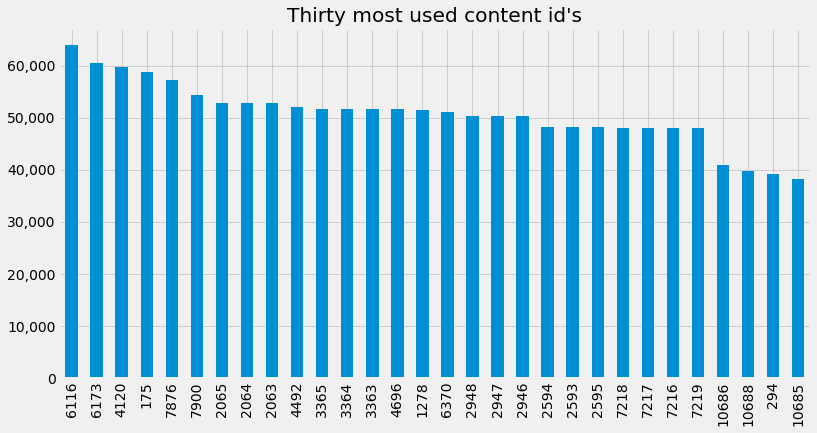

In [13]:
cids = train.content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

task_container_id: (int16) 問題または講義のバッチのIDコードです。例えば、ユーザーは解説を見る前に、3つの質問を連続して見ることができます。これらの3つはすべてtask_container_idを共有します。

In [14]:
print(f'We have {train.task_container_id.nunique()} unique Batches of questions or lectures.')

We have 10000 unique Batches of questions or lectures.


User answer. Seems that the questions are multiple choice (answers 0-3). As mentioned in the data description, -1 is actually no-answer (as the interaction was a lecture instead of a question).

ユーザーの回答です。質問は多肢選択式（回答は0〜3）になっているようです。データの説明にあるように、-1は実際には無回答です（インタラクションが質問ではなく講義であったため）。

In [15]:
train.user_answer.value_counts()

 0    8433345
 1    8071930
 3    7807843
 2    5391047
-1     583950
Name: user_answer, dtype: int64

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user. As you can see, most interactions are from users that were not active very long on the platform yet.

timestamp: (int64) このユーザーインタラクションから、そのユーザーからの最初のイベント完了までの時間（ミリ秒単位）。ご覧の通り、ほとんどのインタラクションは、まだプラットフォーム上であまり長く活動していないユーザーからのものです。

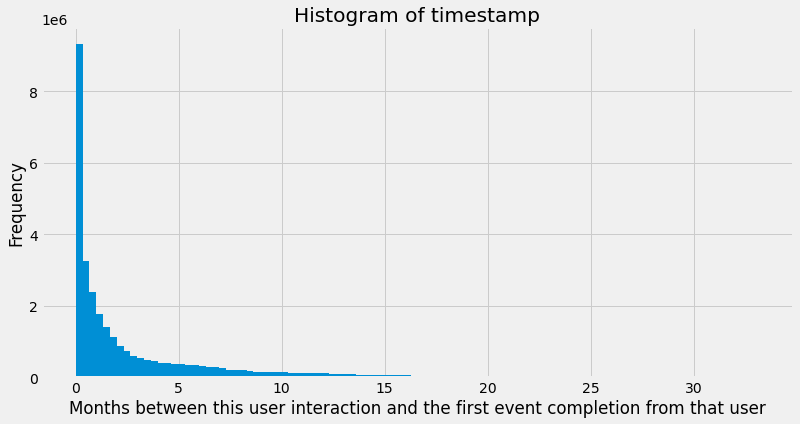

In [16]:
#1 year = 31536000000 ms
ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

Do we have the full history of all user_id's? Yes, if we filter train on timestamp==0, we get a time 0 for all users.

In [17]:
print(f'Of the {train.user_id.nunique()} users in train we have {train[train.timestamp == 0].user_id.nunique()} users with a timestamp zero row.')

Of the 118097 users in train we have 118097 users with a timestamp zero row.


# The target: answered_correctly
Answered_correctly is our target, and we have to predict to probability for an answer to be correct. Without looking at the lecture interactions (-1), we see about 1/3 of the questions was answered incorrectly.

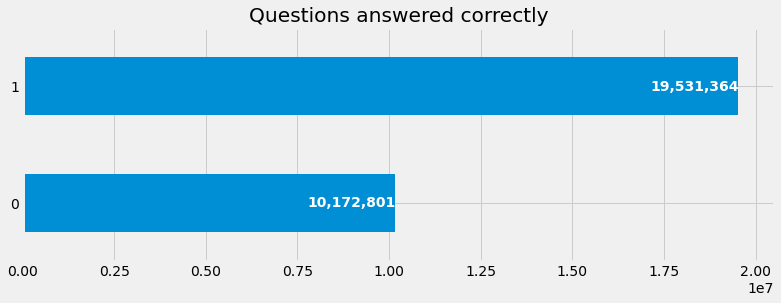

In [18]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()

I also want to find out if there is a relationship between timestamp and answered_correctly. To find out I have made 5 bins of timestamp. As you can see, the only noticable thing is that users who have registered relatively recently perform a little worse than users who are active longer.

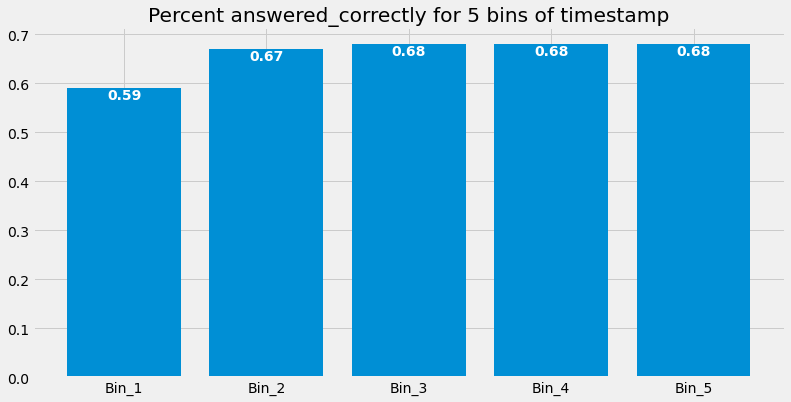

In [19]:
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
train['ts_bin'] = pd.qcut(train['timestamp'], q=5, labels=bin_labels_5)

#make function that can also be used for other fields
def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Percent answered_correctly for 5 bins of timestamp")
plt.xticks(rotation=0)
plt.show()

Let's also check out what the distribution of answered_correctly looks like if we groupby the (10,000 unique) task_container_id's.

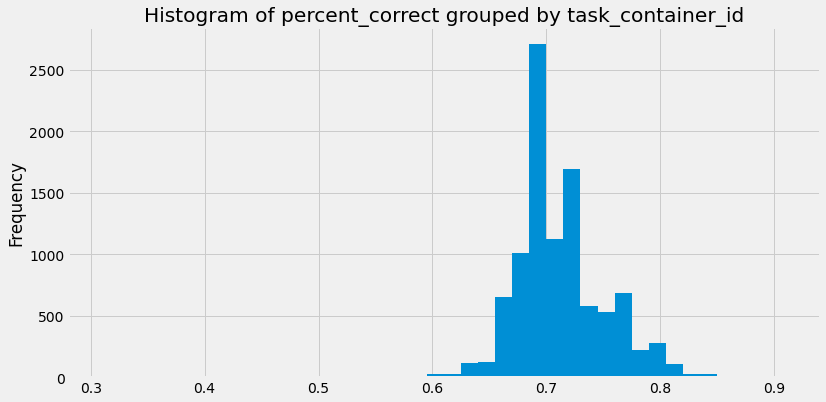

In [20]:
task_id_correct = correct("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Histogram of percent_correct grouped by task_container_id")
plt.xticks(rotation=0)
plt.show()

Below I am plotting the number of answers per user_id against the percentage of questions answered correctly (sample of 200). As some users have answered huge amounts of questions, I have taken out the outliers (user_ids with 1000+ questions answered). As you can see, the trend is upward but there is also a lot of variation among users that have answered few questions.

In [21]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'the highest number of questions answered by a user is {user_percent.Answers.max()}')


the highest number of questions answered by a user is 16424


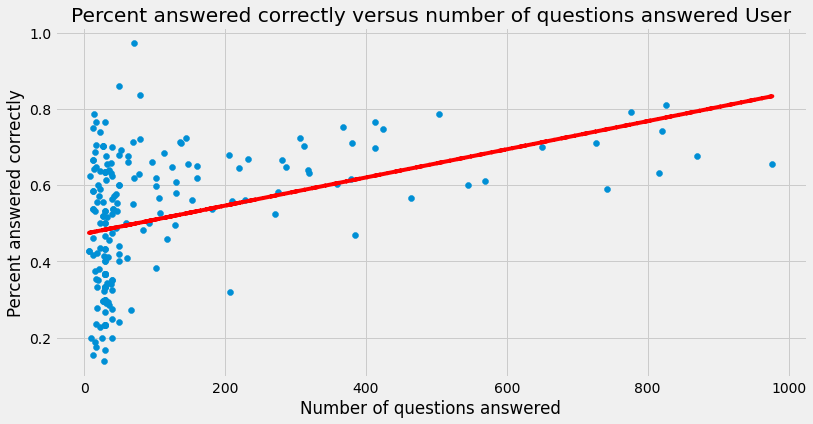

In [22]:
user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()


Below, I am doing the same thing by content_id (is question_id for content_type is question). I am again taking a sample of 200, and have taken out the content_ids with more than 25,000 questions asked. As you can see there is a slight downward trend.

In [23]:
content_percent = train[train.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'The highest number of questions asked by content_id is {content_percent.Answers.max()}.')
print(f'Of {len(content_percent)} content_ids, {len(content_percent[content_percent.Answers > 25000])} content_ids had more than 25,000 questions asked.')

The highest number of questions asked by content_id is 64015.
Of 13516 content_ids, 41 content_ids had more than 25,000 questions asked.


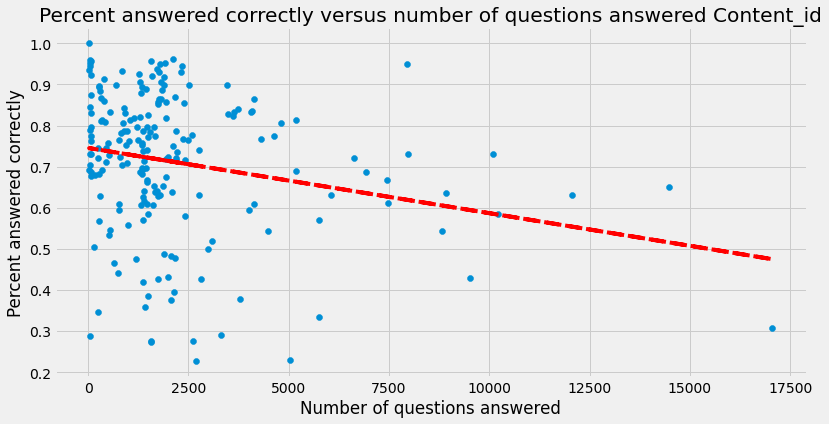

In [24]:
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered Content_id")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()


Does it help if the 'prior_question_had_explanation'? Yes, as you can see the percent answered correctly is about 17% higher when there was an explanation. Although it is probably better to treat not having an explanation as a disadvantage as there was an explanation before the vast majority of questions.

In addition, it is also interesting to see that the percent answered correctly for the missing values is closer to True than to False.

prior_question_had_explanation
False     2767539
True     26818850
NaN        117776
Name: (answered_correctly, count), dtype: int64


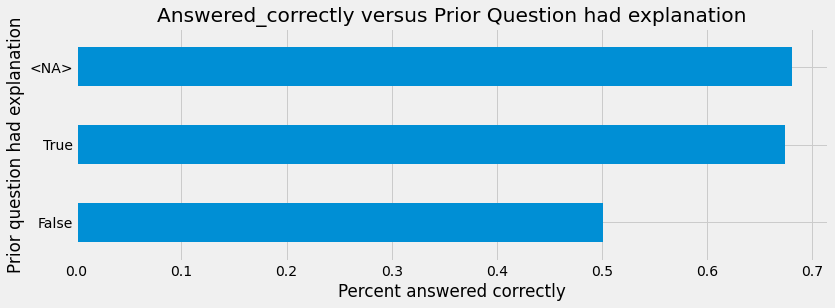

In [25]:
pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
# for i, v in zip(pq.index, pq.values):
#     plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.xticks(rotation=0)
plt.show()

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

At first glance, this does not seem very interesting regarding our target. For both wrong and correct answers, the mean is about 25 seconds.

In [26]:
pq = train[train.answered_correctly != -1]
pq = pq[['prior_question_elapsed_time', 'answered_correctly']]
pq = pq.groupby(['answered_correctly']).agg({'answered_correctly': ['count'], 'prior_question_elapsed_time': ['mean']})

pq

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,10172801,25784.882812
1,19531364,25397.476562


However, as the feature works with regards to the CV (see Baseline model), I also wanted to find out if there is a trend. Below, I have taken a sample of 200 rows. As you can see, there is s slightly downward trend.

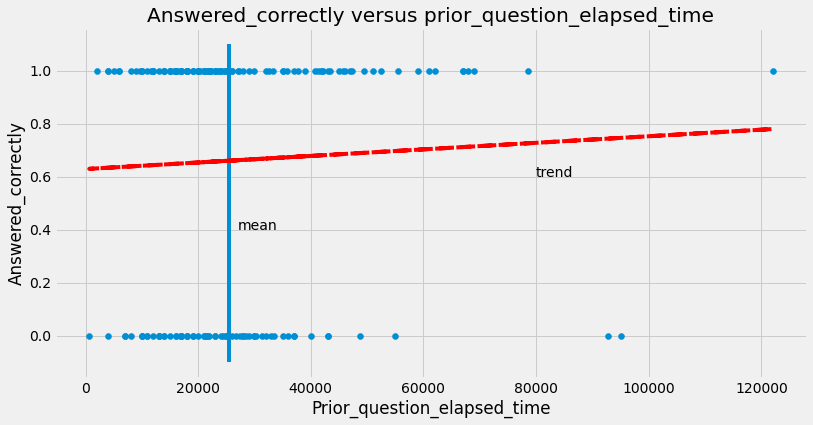

In [27]:
#please be aware that there is an issues with train.prior_question_elapsed_time.mean()
#see https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/195032
mean_pq = train.prior_question_elapsed_time.astype("float64").mean()

condition = ((train.answered_correctly != -1) & (train.prior_question_elapsed_time.notna()))
pq = train[condition][['prior_question_elapsed_time', 'answered_correctly']].sample(n=200, random_state=1)
pq = pq.set_index('prior_question_elapsed_time').iloc[:,0]

fig = plt.figure(figsize=(12,6))
x = pq.index
y = pq.values
plt.scatter(x, y, marker='o')
plt.title("Answered_correctly versus prior_question_elapsed_time")
plt.xticks(rotation=0)
plt.xlabel("Prior_question_elapsed_time")
plt.ylabel("Answered_correctly")
plt.vlines(mean_pq, ymin=-0.1, ymax=1.1)
plt.text(x= 27000, y=0.4, s='mean')
plt.text(x=80000, y=0.6, s='trend')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

# 1.2 Exploring Questions

Metadata for the questions posed to users.

* question_id: foreign key for the train/test content_id column, when the content type is question (0).
* bundle_id: code for which questions are served together.
* correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
* part: the relevant section of the TOEIC test.
* tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.


In [28]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [29]:
questions.shape

(13523, 5)

The tags seem valuable to me. First, let's check if there are any question_id's without tags. As you can see, there is exactly one question_id without at least one tag. Not a big deal, but we need to keep in mind that we have to impute something here if we make features based on tags.

In [30]:
questions[questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Also.....when looking at train, we see that this question was just asked once ;-). 

In [31]:
train.query('content_id == "10033" and answered_correctly != -1')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,ts_bin


In [32]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

There are 188 different tags


Let's find out how many answers were Right and Wrong per question_id (so per content_id in train).

In [33]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",198.0,1952.0
1,1,1,1,1,"[131, 36, 81]",261.0,2035.0
2,2,2,0,1,"[131, 101, 162, 92]",5885.0,7462.0
3,3,3,0,1,"[131, 149, 162, 29]",1521.0,5445.0
4,4,4,3,1,"[131, 5, 162, 38]",3726.0,5792.0


As you can see, I have also changed the tags column into lists of tags.

In [34]:
questions.tags.values

array([list(['51', '131', '162', '38']), list(['131', '36', '81']),
       list(['131', '101', '162', '92']), ..., list(['73']),
       list(['125']), list(['55'])], dtype=object)

Now, I can add up all Wrong and Right answers for all questions that are labeled with a particular tag and calculate the percent correct for each tag. Please note that there is "double counting" of questions; for instance if a question has 5 tags, its answers are aggregated in the totals of each of the 5 tags. 

In [35]:
%%time

tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

CPU times: user 1.42 s, sys: 254 µs, total: 1.42 s
Wall time: 1.42 s


,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,46828,29812,76640,17,0.388987
23,78720,61147,139867,11,0.437180
19,51474,40828,92302,57,0.442331
151,81668,79453,161121,16,0.493126
167,51322,51183,102505,11,0.499322


As you can see, the differences are significant!

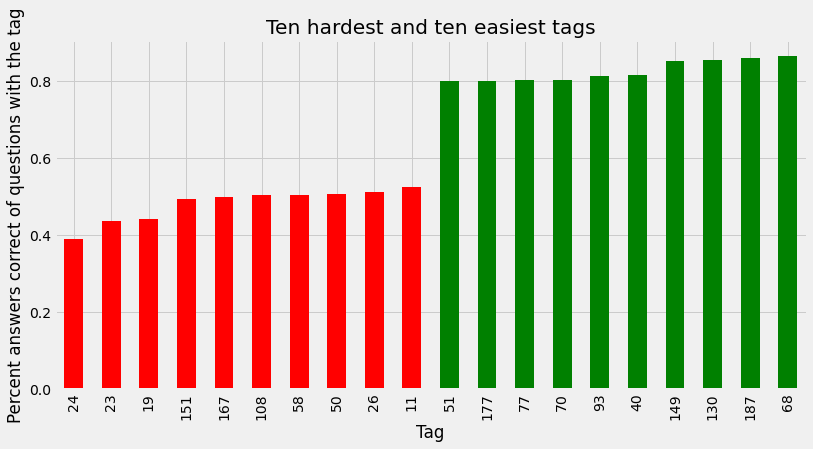

In [36]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Ten hardest and ten easiest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct of questions with the tag")
plt.xticks(rotation=90)
plt.show()

However, we should also realize that the tag with the worst percent_correct only has about 250,000 answers. This a low number compared to the tags with most answers.

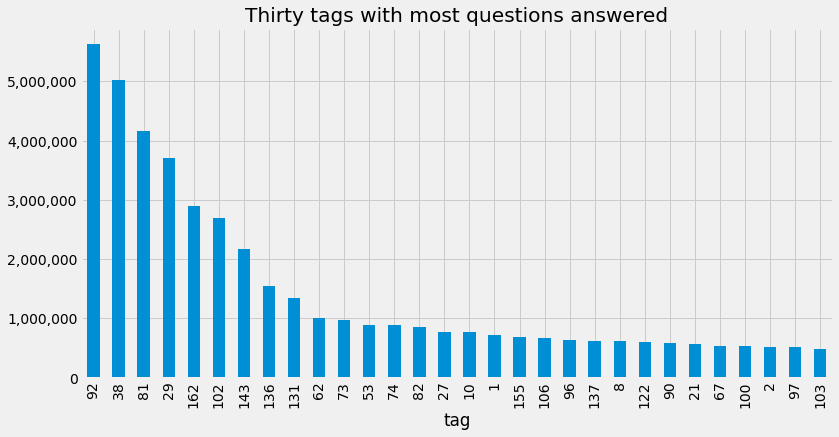

In [37]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("Thirty tags with most questions answered")
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

What are the so-called "Parts"? When following the link provided in the data description we find out that this relates to a test.

> The TOEIC L&R uses an optically-scanned answer sheet. There are 200 questions to answer in two hours in Listening (approximately 45 minutes, 100 questions) and Reading (75 minutes, 100 questions). 

The listening section consists of Part 1-4 (Listening Section (approx. 45 minutes, 100 questions)).

The reading section consists of Part 5-7 (Reading Section (75 minutes, 100 questions)).

Below, I am displaying the count and percent correct by part. As you can see, Part 5 has a lot more question_id's and is also the most difficult.

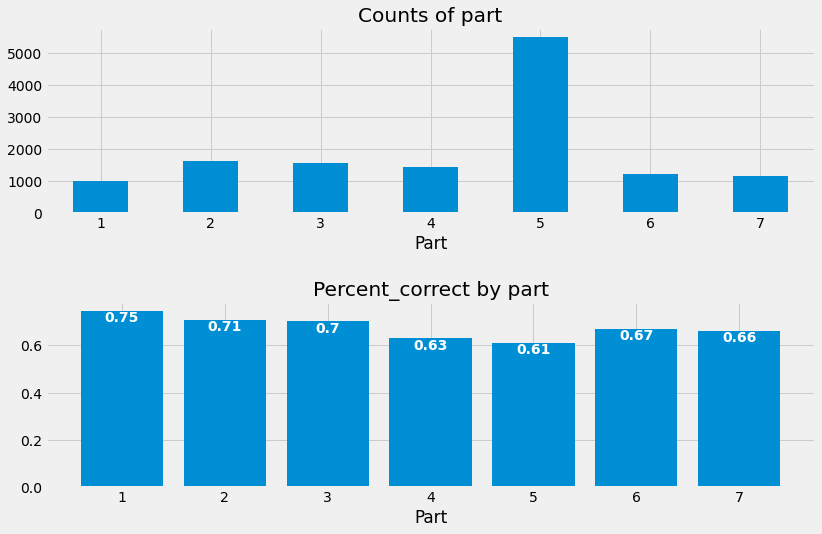

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby("part").count()['question_id'].plot.bar()
plt.title("Counts of part")
plt.xlabel("Part")
plt.xticks(rotation=0)

part = questions.groupby('part').agg({'Wrong': ['sum'], 'Right': ['sum']})
part['Percent_correct'] = part.Right/(part.Right + part.Wrong)
part = part.iloc[:,2]

ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')

plt.title("Percent_correct by part")
plt.xlabel("Part")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

# 1.3 Exploring Lectures

Metadata for the lectures watched by users as they progress in their education.
* lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
* part: top level category code for the lecture.
* tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
* type_of: brief description of the core purpose of the lecture


In [39]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [40]:
print(f'There are {lectures.shape[0]} lecture_ids.')

There are 418 lecture_ids.


Let's have a look at the type_of.

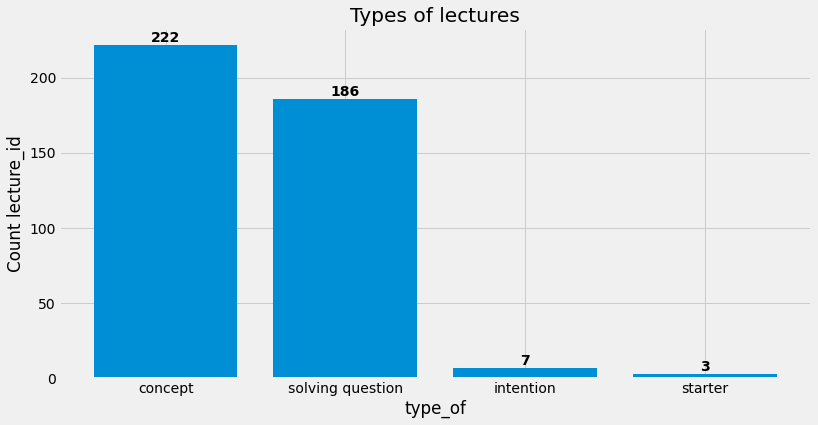

In [41]:
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

Since there are not that many lectures, I want to check if it helps if a user watches lectures at all. As you can see, it helps indeed!

False    73402
True     44695
Name: Watches_lecture, dtype: int64


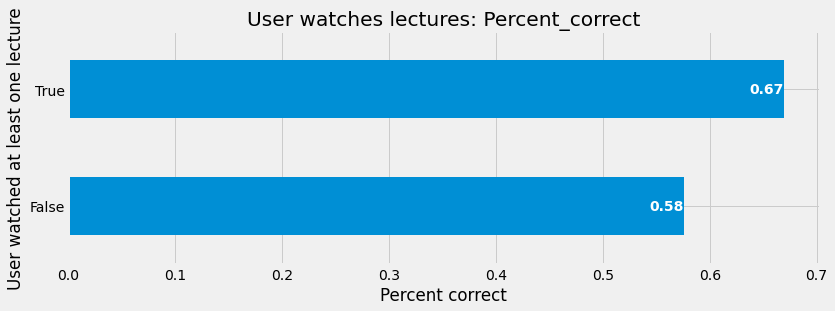

In [42]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

Batches (task_container_id) may also contain lectures, and I want to find out if there are any batches with high numbers of lectures.

In [43]:
batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

The highest number of lectures watched within a single task_container_id is 1542.


As you can see below (table sorted on descending Percent_lecture), the percent of lectures of the task_container_id's is never high. We can also see the highest percentages of lectures are around 2.8%, which means one lecture on about 36 questions.

In [44]:
batch_lect.head()

,Lecture,Wrong,Right,Percent_correct,Percent_lecture
task_container_id,,,,,
8882,4,14,62,0.815789,0.05
8529,5,25,76,0.752475,0.04717
9170,3,20,45,0.692308,0.044118
9703,3,24,42,0.636364,0.043478
9975,2,14,30,0.681818,0.043478


Is there a correlation between the percent_lecture and the percent_correct? No, I don't really see it. If anything, the percent_correct actually seems to go down slightly.

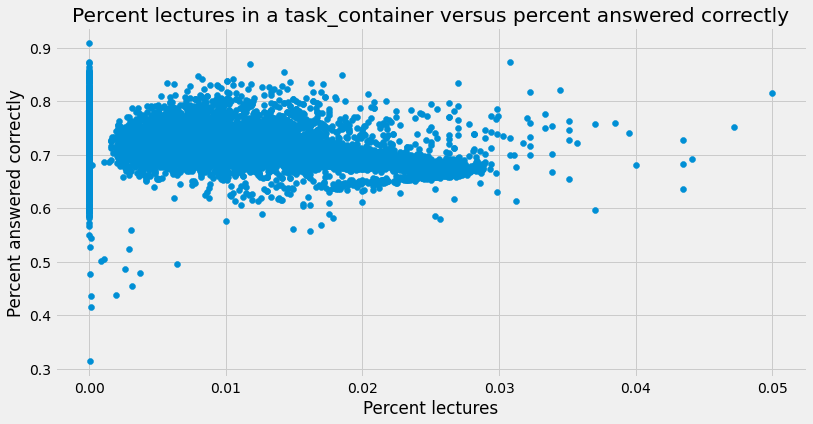

In [45]:
batch = batch_lect.iloc[:, 3:]

fig = plt.figure(figsize=(12,6))
x = batch.Percent_lecture
y = batch.Percent_correct
plt.scatter(x, y, marker='o')
plt.title("Percent lectures in a task_container versus percent answered correctly")
plt.xticks(rotation=0)
plt.xlabel("Percent lectures")
plt.ylabel("Percent answered correctly")

plt.show()


The last thing that I want to check is if having a lecture in a batch helps. As you can see, it does not. Batches without lectures have about 8% more correct answers than batches with lectures.

In [46]:
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f'We have {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids with lectures and {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids without lectures.')

We have 7728 task_container_ids with lectures and 2272 task_container_ids without lectures.


In [47]:
batch_lect = batch_lect[['Wrong', 'Right', 'Has_lecture']]
batch_lect = batch_lect.groupby("Has_lecture").sum()
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect[['Percent_correct']]
batch_lect

,Percent_correct
Has_lecture,
False,0.732084
True,0.656835


# Example test
This file is a very small file, and only good to check what's in there.

Important: In the `Updates, corrections, and clarifications` topic is said that:
* the hidden test set contains new users but not new questions
* The train/test data is complete, in the sense that there are no missing interactions in the union of train and test data. It remains possible that some questions weren't logged due to other issues that all datasets of mobile users are susceptible to,such as if a user lost their connection mid-question.
* The test data follows chronologically after the train data. The test iterations give interactions of users chronologically.

このファイルは非常に小さなファイルですので、中身を確認する程度にご利用ください。

重要: 更新、修正、および明確化のトピックでは、次のように述べられています。

隠されたテストセットには新しいユーザは含まれますが、新しい問題は含まれません。
訓練データとテストデータの結合に欠落した相互作用がないという意味で、訓練/テストデータは完全です。ただし、質問の途中で接続が切れた場合など、モバイルユーザーのすべてのデータセットが影響を受けやすい問題により、いくつかの質問が記録されなかった可能性があります。
テストデータは訓練データの後に時系列で続きます。テスト反復では、ユーザーのインタラクションが時系列で表示される。

In [48]:
example_test.shape

(104, 11)

In [49]:
example_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


In [50]:
batches_test = set(list(example_test.task_container_id.unique()))
batches_train = set(list(train.task_container_id.unique()))
print(f'All batches in example_test are also in train is {batches_test.issubset(batches_train)}.')

All batches in example_test are also in train is True.


Kaggle says that there are new users in the test set, but let's check this anyway with example_test. As we can see, there is a new user in example_test indeed.

Kaggleは、テストセットに新しいユーザーがいると言っていますが、とりあえずexample_testで確認してみましょう。見ての通り、example_testには確かに新しいユーザがいます。

In [51]:
user_test = set(list(example_test.user_id.unique()))
user_train = set(list(train.user_id.unique()))

print(f'User_ids in example_test but not in train: {user_test - user_train}.')

User_ids in example_test but not in train: {1900527744, 1317245193, 555691277, 1817433235, 706626847, 1637273633, 311890082, 98059812, 1422853669, 1468996389, 1310228392, 1728340777, 1720860329, 7792299, 1202386221, 2018567473, 1148874033, 1305988022, 1233875513, 275030867, 1364159702, 1700555100, 319060572, 1357500007, 554169193, 385471210, 2030979309, 1981166446, 674533997, 1599808246}.


# 2. Baseline model

TODO: 以下のコードを実行したいが，他のcsvファイルもtarget_idで抽出すべき？
```python
target_id = pd.Series(train.user_id.unique()).sample(frac=0.3)
train = train[train['user_id'].isin(target_id)]
```


In [4]:
#this clears everything loaded in RAM, including the libraries
%reset -f

In [5]:
import numpy as np
import pandas as pd
import sys
import importlib

sys.path.append('../input/')
riiideducation = importlib.import_module("riiid-test-answer-prediction.riiideducation")
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import gc
import sys
pd.set_option('display.max_rows', None)

In [6]:
%%time
cols_to_load = ['row_id', 'user_id', 'answered_correctly', 'content_id', 'prior_question_had_explanation', 'prior_question_elapsed_time']
train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")[cols_to_load]
# sampling
target_id = pd.Series(train.user_id.unique()).sample(frac=0.3)
train = train[train['user_id'].isin(target_id)]

train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')
print("Train size:", train.shape)

Train size: (30469508, 6)
CPU times: user 13.4 s, sys: 4.92 s, total: 18.3 s
Wall time: 22.7 s


In [9]:
%%time
questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
#questions = questions[questions['user_id'].isin(target_id)]
lectures = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')
#lectures = lectures[lectures['user_id'].isin(target_id)]

example_test = pd.read_csv('../input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('../input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 13.9 ms


In [57]:
train.head()

,row_id,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time
0,0,115,1,5692,<NA>,NaN
1,1,115,1,5716,False,37000.0
2,2,115,1,128,False,55000.0
3,3,115,1,7860,False,19000.0
4,4,115,1,7922,False,11000.0


In [58]:
train.shape

(101230332, 6)

Below, I am adding user features. **Dislaimer**: This a quick and dirty way. Future information should not be used. For instance, the percent answered_correctly for a user's 10th question should be the average of his first 9 answers only. However, that would make this baseline model a lot more complicated. You can find the correct way to compose user features in all high scoring public notebooks (which use loops to calculate values for each individual question).

以下、ユーザー機能を追加しています。**Dislaimer**: これは手っ取り早く、汚い方法です。未来の情報は使うべきではない。例えば、ユーザーの10番目の質問に対するanswered_correctlyのパーセントは、彼の最初の9つの回答の平均のみにすべきです。しかし、それはこのベースラインモデルをより複雑にしてしまいます。ユーザーの特徴を構成する正しい方法は、すべての高得点公開ノートブック（個々の問題に対して値を計算するループを使用している）で見つけることができます。

In [59]:
%%time
#adding user features
user_df = train[train.answered_correctly != -1].groupby('user_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
user_df.columns = ['user_id', 'user_questions', 'user_mean']

user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect = user_lect[['Lecture']].fillna(0).astype('int8')
#user_lect = user_lect.astype('int8')
user_lect['watches_lecture'] = np.where(user_lect.Lecture > 0, 1, 0)
user_lect = user_lect.reset_index()
user_lect = user_lect[['user_id', 'watches_lecture']]

user_df = user_df.merge(user_lect, on = "user_id", how = "left")
del user_lect
user_df.head()

CPU times: user 8.11 s, sys: 1.65 s, total: 9.76 s
Wall time: 9.77 s


,user_id,user_questions,user_mean,watches_lecture
0,115,46,0.695652,0
1,124,30,0.233333,0
2,2746,19,0.578947,1
3,5382,125,0.672000,1
4,8623,109,0.642202,1


For content features, the story is different. If we had "real" points in time, we would have had the option to track changes in difficulty over time. However, timestamp 0 for user x is not the same as timestamp 0 for user y. Therefore, we do not have the option to compare timestamps across users and the "average-based "content features are as good as it gets for this dataset.

In [60]:
%%time
#adding content features
content_df = train[train.answered_correctly != -1].groupby('content_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
content_df.columns = ['content_id', 'content_questions', 'content_mean']
content_df.head()


CPU times: user 4.97 s, sys: 651 ms, total: 5.62 s
Wall time: 5.62 s


,content_id,content_questions,content_mean
0,0,6903,0.907721
1,1,7398,0.890646
2,2,44905,0.554281
3,3,22973,0.779437
4,4,31736,0.613215


Tito rightfully argues that just taking the last couple of questions from each user as the validation set leads to much on "light users" in this kernel (Thanks Tito!): https://www.kaggle.com/its7171/cv-strategy

In [61]:
%%time
#using one of the validation sets composed by tito
cv2_train = pd.read_pickle("../input/riiid-cross-validation-files/cv2_train.pickle")['row_id']
cv2_valid = pd.read_pickle("../input/riiid-cross-validation-files/cv2_valid.pickle")['row_id']

CPU times: user 1.68 s, sys: 7.46 s, total: 9.14 s
Wall time: 16.1 s


In [62]:
train = train[train.answered_correctly != -1]

#save mean before splitting
#please be aware that there is an issues with train.prior_question_elapsed_time.mean()
#see https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/195032
mean_prior = train.prior_question_elapsed_time.astype("float64").mean()

validation = train[train.row_id.isin(cv2_valid)]
train = train[train.row_id.isin(cv2_train)]

validation = validation.drop(columns = "row_id")
train = train.drop(columns = "row_id")

del cv2_train, cv2_valid
gc.collect()

72

ここで，以下の画面が表示され強制終了してしまう.

メモリが不足しているときに表示されるメッセージらしい.


--------------------------------------

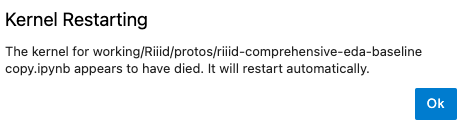

--------------------------------------

In the previous version, I made a function for all the merges, fillna's and label encoding below. However, after adding a few features in this version, I ran into memory issues. I seemed as if a copy of train was kept in RAM at least temporarily, and I ran into an out-of memory error. Therefore, I unfortunately went back to an ugly version of code repetition for those steps (same code for validation and test_df).

In [ ]:
label_enc = LabelEncoder()

train = train.merge(user_df, on = "user_id", how = "left")
train = train.merge(content_df, on = "content_id", how = "left")
train['content_questions'].fillna(0, inplace = True)
train['content_mean'].fillna(0.5, inplace = True)
train['watches_lecture'].fillna(0, inplace = True)
train['user_questions'].fillna(0, inplace = True)
train['user_mean'].fillna(0.5, inplace = True)
train['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
train['prior_question_had_explanation'].fillna(False, inplace = True)
label_enc.fit(train['prior_question_had_explanation'])
train['prior_question_had_explanation'] = label_enc.transform(train['prior_question_had_explanation'])
train[['content_questions', 'user_questions']] = train[['content_questions', 'user_questions']].astype(int)
train.sample(5)

In [ ]:
validation = validation.merge(user_df, on = "user_id", how = "left")
validation = validation.merge(content_df, on = "content_id", how = "left")
validation['content_questions'].fillna(0, inplace = True)
validation['content_mean'].fillna(0.5, inplace = True)
validation['watches_lecture'].fillna(0, inplace = True)
validation['user_questions'].fillna(0, inplace = True)
validation['user_mean'].fillna(0.5, inplace = True)
validation['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
validation['prior_question_had_explanation'].fillna(False, inplace = True)
validation['prior_question_had_explanation'] = label_enc.transform(validation['prior_question_had_explanation'])
validation[['content_questions', 'user_questions']] = validation[['content_questions', 'user_questions']].astype(int)
validation.sample(5)

As you can see below, I am using only 5 features for this baseline. Initially, I also included "watches_lecture" and "prior_question_had_explanation", but these two features are very questionable. With those two features, CV barely goes up (less than 0.001), the public score goes down 0.001 and feature importance is very low for both features. Therefore, I believe that the simpler model is preferred. If you want still check what the numbers look like with those features, you can do that by simply hashing in and out the features line.

In [ ]:
# features = ['user_questions', 'user_mean', 'content_questions', 'content_mean', 'watches_lecture',
#             'prior_question_elapsed_time', 'prior_question_had_explanation']

features = ['user_questions', 'user_mean', 'content_questions', 'content_mean', 'prior_question_elapsed_time']


#for now just taking 10.000.000 rows for training
train = train.sample(n=10000000, random_state = 1)

y_train = train['answered_correctly']
train = train[features]

y_val = validation['answered_correctly']
validation = validation[features]


In [ ]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }

In [ ]:
lgb_train = lgb.Dataset(train, y_train, categorical_feature = None)
lgb_eval = lgb.Dataset(validation, y_val, categorical_feature = None)
del train, y_train, validation, y_val
gc.collect()

In [ ]:
%%time
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8
)

In [ ]:
lgb.plot_importance(model)
plt.show()

In [ ]:
env = riiideducation.make_env()

In [ ]:
iter_test = env.iter_test()

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df.merge(user_df, on = "user_id", how = "left")
    test_df = test_df.merge(content_df, on = "content_id", how = "left")
    test_df['content_questions'].fillna(0, inplace = True)
    test_df['content_mean'].fillna(0.5, inplace = True)
    test_df['watches_lecture'].fillna(0, inplace = True)
    test_df['user_questions'].fillna(0, inplace = True)
    test_df['user_mean'].fillna(0.5, inplace = True)
    test_df['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace = True)
    test_df['prior_question_had_explanation'] = label_enc.transform(test_df['prior_question_had_explanation'])
    test_df[['content_questions', 'user_questions']] = test_df[['content_questions', 'user_questions']].astype(int)
    test_df['answered_correctly'] =  model.predict(test_df[features])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])